# Perpendicular Direction Sweep

Test whether grade level changes along the perpendicular direction.

**Hypothesis:** Since V_perpendicular is orthogonal to V_complexity, steering along it (varying β while holding α=0) should NOT significantly affect grade level.

**Method:**
- Prompt: "Can you explain quantum mechanics please?"
- α = 0.0 (no steering along complexity)
- β = -5.0 to 5.0 in steps of 1.0
- Measure FK grade level at each β

**Expected result:** Flat line (grade level ~12-14 based on baseline)

In [17]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import textstat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Configuration

In [18]:
MODEL_NAME = "unsloth/Llama-3.2-3B-Instruct"
DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
STEERING_LAYER = 27

# Test configuration
TEST_PROMPT = "Can you explain quantum mechanics please?"
ALPHA = 0.0  # No steering along complexity
BETA_MIN = -10.0
BETA_MAX = 10.0
BETA_STEP = 1.0

# Generation parameters
MAX_NEW_TOKENS = 200

print(f"Device: {DEVICE}")

Device: mps


## Load model and vectors

In [19]:
print(f"Loading model: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() or torch.backends.mps.is_available() else torch.float32,
    device_map="auto",
)
model.eval()
print("✓ Model loaded")

Loading model: unsloth/Llama-3.2-3B-Instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Model loaded


In [20]:
# Load vectors
vectors = torch.load('vectors/complexity_vectors.pt')
v_complexity = vectors[STEERING_LAYER]
v_perpendicular = torch.load('vectors/perpendicular_vector.pt')

print(f"V_complexity shape: {v_complexity.shape}, L2 norm: {torch.norm(v_complexity).item():.4f}")
print(f"V_perpendicular shape: {v_perpendicular.shape}, L2 norm: {torch.norm(v_perpendicular).item():.4f}")

# Verify orthogonality
dot_product = torch.dot(v_complexity, v_perpendicular).item()
print(f"Dot product (should be ~0): {dot_product}")

V_complexity shape: torch.Size([3072]), L2 norm: 9.8750
V_perpendicular shape: torch.Size([3072]), L2 norm: 9.8750
Dot product (should be ~0): 0.00066375732421875


## Steering functions

In [21]:
def generate_with_steering(prompt, alpha, beta):
    """Generate text with 2D steering: alpha * V_complexity + beta * V_perpendicular."""
    # Format prompt using chat template
    messages = [{"role": "user", "content": prompt}]
    formatted_prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    
    inputs = tokenizer(formatted_prompt, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Compute combined steering vector
    steering_vector = (alpha * v_complexity + beta * v_perpendicular).to(model.device)
    
    # Define steering hook
    def steering_hook(module, input, output):
        if isinstance(output, tuple):
            hidden_states = output[0]
        else:
            hidden_states = output
        steered = hidden_states + steering_vector.unsqueeze(0).unsqueeze(0)
        if isinstance(output, tuple):
            return (steered,) + output[1:]
        else:
            return steered
    
    # Register hook
    hook_handle = model.model.layers[STEERING_LAYER].register_forward_hook(steering_hook)
    
    try:
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=MAX_NEW_TOKENS,
                do_sample=False,  # Greedy decoding for reproducibility
            )
        full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    finally:
        hook_handle.remove()
    
    # Extract assistant response
    if "<|start_header_id|>assistant<|end_header_id|>" in full_text:
        generated_text = full_text.split("<|start_header_id|>assistant<|end_header_id|>", 1)[1]
        generated_text = generated_text.lstrip('\n')
    else:
        generated_text = full_text[len(prompt):].strip()
    
    # Clean up special tokens
    for token in ["<|eot_id|>", "<|end_of_text|>", "<|im_end|>", "<|endoftext|>"]:
        if token in generated_text:
            generated_text = generated_text.split(token)[0]
    
    return generated_text.strip()


def analyze_text(text):
    """Compute FK grade level and other metrics."""
    if not text or len(text.strip()) < 10:
        return {
            'flesch_kincaid_grade': 0.0,
            'word_count': 0,
            'sentence_count': 0,
        }
    
    try:
        return {
            'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
            'word_count': textstat.lexicon_count(text, removepunct=True),
            'sentence_count': textstat.sentence_count(text),
        }
    except:
        return {
            'flesch_kincaid_grade': 0.0,
            'word_count': 0,
            'sentence_count': 0,
        }

print("✓ Functions defined")

✓ Functions defined


## Run the sweep

In [22]:
print(f"Running perpendicular sweep: β from {BETA_MIN} to {BETA_MAX}, α = {ALPHA}\n")

betas = np.arange(BETA_MIN, BETA_MAX + BETA_STEP/2, BETA_STEP)
results = []

for beta in betas:
    print(f"β = {beta:+.1f}...")
    
    # Generate text
    text = generate_with_steering(TEST_PROMPT, ALPHA, beta)
    
    # Analyze
    metrics = analyze_text(text)
    
    # Store
    results.append({
        'beta': beta,
        'alpha': ALPHA,
        'generated_text': text,
        **metrics
    })
    
    print(f"  Grade level: {metrics['flesch_kincaid_grade']:.1f}, Words: {metrics['word_count']}\n")

df = pd.DataFrame(results)
print("✓ Sweep complete")

Running perpendicular sweep: β from -10.0 to 10.0, α = 0.0

β = -10.0...
  Grade level: 60.3, Words: 213

β = -9.0...
  Grade level: 60.3, Words: 213

β = -8.0...
  Grade level: 37.8, Words: 210

β = -7.0...
  Grade level: 12.8, Words: 154

β = -6.0...
  Grade level: 12.9, Words: 153

β = -5.0...
  Grade level: 13.4, Words: 155

β = -4.0...
  Grade level: 12.8, Words: 158

β = -3.0...
  Grade level: 12.3, Words: 151

β = -2.0...
  Grade level: 12.6, Words: 161

β = -1.0...
  Grade level: 14.3, Words: 156

β = +0.0...
  Grade level: 14.4, Words: 156

β = +1.0...
  Grade level: 13.7, Words: 161

β = +2.0...
  Grade level: 13.7, Words: 161

β = +3.0...
  Grade level: 10.8, Words: 169

β = +4.0...
  Grade level: 11.2, Words: 165

β = +5.0...
  Grade level: 10.8, Words: 166

β = +6.0...
  Grade level: 10.9, Words: 158

β = +7.0...
  Grade level: 12.6, Words: 152

β = +8.0...
  Grade level: 46.9, Words: 208

β = +9.0...
  Grade level: 49.0, Words: 210

β = +10.0...
  Grade level: 343.9, Word

## Visualize results

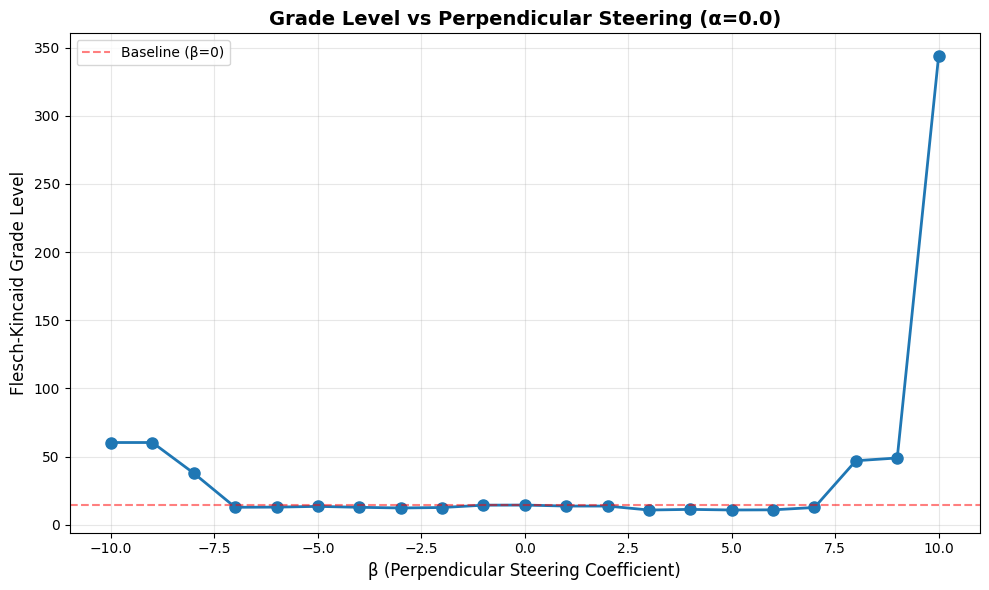


Grade level range: 10.8 to 343.9
Baseline (β=0): 14.4


In [23]:
plt.figure(figsize=(10, 6))
plt.plot(df['beta'], df['flesch_kincaid_grade'], marker='o', linewidth=2, markersize=8)
plt.axhline(df[df['beta'] == 0.0]['flesch_kincaid_grade'].values[0], 
            color='red', linestyle='--', alpha=0.5, label='Baseline (β=0)')
plt.xlabel('β (Perpendicular Steering Coefficient)', fontsize=12)
plt.ylabel('Flesch-Kincaid Grade Level', fontsize=12)
plt.title(f'Grade Level vs Perpendicular Steering (α={ALPHA})', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nGrade level range: {df['flesch_kincaid_grade'].min():.1f} to {df['flesch_kincaid_grade'].max():.1f}")
print(f"Baseline (β=0): {df[df['beta'] == 0.0]['flesch_kincaid_grade'].values[0]:.1f}")

## Save results

In [24]:
df.to_csv('data/perpendicular_sweep_results.csv', index=False)
print("✓ Saved to data/perpendicular_sweep_results.csv")

✓ Saved to data/perpendicular_sweep_results.csv


## Linear regression analysis

Quantify how flat the perpendicular direction is within the coherent regime (-7 to +7).

In [25]:
from scipy import stats

# Filter to coherent regime (-7 to +7)
df_coherent = df[(df['beta'] >= -7) & (df['beta'] <= 7)].copy()

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_coherent['beta'], 
    df_coherent['flesch_kincaid_grade']
)

r_squared = r_value**2

print("Linear Regression Analysis (β ∈ [-7, 7])")
print("=" * 50)
print(f"Slope: {slope:.4f} grade levels per β unit")
print(f"Intercept: {intercept:.4f}")
print(f"R²: {r_squared:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Standard error: {std_err:.4f}")
print()
print("Interpretation:")
print(f"  - For comparison, V_complexity has slope ≈ 2.4 GL/α")
print(f"  - V_perpendicular has slope = {slope:.4f} GL/β")
print(f"  - V_perp effect is {abs(2.4/slope):.1f}x smaller than V_complexity" if slope != 0 else "  - V_perp has zero effect!")
print(f"  - R² = {r_squared:.4f} indicates {'strong' if r_squared > 0.7 else 'moderate' if r_squared > 0.4 else 'weak'} linear relationship")

Linear Regression Analysis (β ∈ [-7, 7])
Slope: -0.1266 grade levels per β unit
Intercept: 12.6050
R²: 0.2154
P-value: 8.1413e-02
Standard error: 0.0670

Interpretation:
  - For comparison, V_complexity has slope ≈ 2.4 GL/α
  - V_perpendicular has slope = -0.1266 GL/β
  - V_perp effect is 19.0x smaller than V_complexity
  - R² = 0.2154 indicates weak linear relationship
